# LeNet

In [1]:
import torch

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
device

'cpu'

## Die Daten

### MNIST-Datensatz laden und transformieren

In [4]:
import torchvision
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


### Aufteilen in Batches

In [5]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

#### Anzeige einiger Beispiele

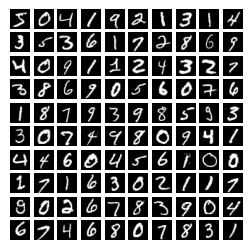

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 10, figsize=(3,3))

for n, ax in enumerate(axs.flat):
    image, _ = train_data[n]
    ax.imshow(image.permute(1,2,0), cmap='grey')
    ax.axis('off')  

## Das Modell

### Entwurf des Modells

### Das LeNet-Modell

* Convolutional layers can be created as `nn.Conv2d(N, C, K)`. For input images of size `W×H`, the output feature maps have size `[W−K+1]x[H−K+1]`.  

* Maxpooling is implemented like any other non-linear function (such as ReLU or softmax). For input images of size `W×H`, the output feature maps have size `[W/L]×[H/L]`.  

* A fully connected layer can be created as `nn.Linear(M, N)`.

Architecture:  

(a) a convolutional layer connecting the input image to `6` feature maps with `5×5` convolutions (`K=5`) and followed by ReLU and maxpooling (`L=2`)  

(b) a convolutional layer connecting the `6` input channels to `16` output channels with `5×5` convolutions and followed by ReLU and maxpooling (`L=2`)  

(c) a fully-connected layer connecting `16` feature maps to `120` output units and followed by ReLU  

(d) a fully-connected layer connecting `120` inputs to `84` output units and followed by ReLU  

(e) a final linear layer connecting `84` inputs to `10` linear outputs (one for each of our digits)

First layer  
* input: `(28, 28, 1)`  
* after *padding*: `(32, 32, 1)`
* after convolution(kernel=`5x5`): `(28, 28, 6)` where `28=32-5+1`  
* after ReLU: `(28, 28, 6)`  
* after maxpooling(stride=`2x2`): `(14, 14, 6)` $\Rightarrow$ **OUTPUT**  


Second layer
* input: `(14, 14, 6)`
* after convolution(kernel=`5x5`): `(10, 10, 16)`
* after ReLU: `(10, 10, 16)`  
* after maxpooling(stride=`2x2`): `(5, 5, 16)` $\Rightarrow$ **OUTPUT**  


Third layer
* input: `(5, 5, 16)` $\Rightarrow$ `5x5x16=400`  
* after fully-connected: `(120, 1)`
* after ReLU: `(120, 1)` $\Rightarrow$ **OUTPUT**  


Fourth layer
* input: `(120, 1)`
* after fully-connected: `(84, 1)`
* after ReLU: `(84, 1)` $\Rightarrow$ **OUTPUT**  


Fifth layer
* input: `(84, 1)`
* after fully-connected: `(10, 1)`
* after ReLU: `(10, 1)` $\Rightarrow$ **OUTPUT**  

In [7]:
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(42)

import numpy as np

class LeNet(nn.Module):

    # network structure
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        self.c1 = self.c2 = None

    def forward(self, x):
        self.c1 = c1 = F.relu(self.conv1(x))
        self.c1 = x = F.max_pool2d(c1, (2, 2))
        self.c2 = c2  = F.relu(self.conv2(x))
        self.c2 = x = F.max_pool2d(c2, (2, 2))
 
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        return np.prod(size)

     

In [8]:
import torch.optim as optim
model = LeNet().to(device)

In [9]:
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Check the network parameters

In [10]:
for name, param in model.named_parameters():
    print(name, param.size(), param.requires_grad)

conv1.weight torch.Size([6, 1, 5, 5]) True
conv1.bias torch.Size([6]) True
conv2.weight torch.Size([16, 6, 5, 5]) True
conv2.bias torch.Size([16]) True
fc1.weight torch.Size([120, 400]) True
fc1.bias torch.Size([120]) True
fc2.weight torch.Size([84, 120]) True
fc2.bias torch.Size([84]) True
fc3.weight torch.Size([10, 84]) True
fc3.bias torch.Size([10]) True


### Training des Modells

(Mini-Batch) Stochastic Gradient Descent (SGD) with cross-entropy and momentum
**Note**: PyTorch’s CrossEntropyLoss is the composition of a softmax activation with the standard cross-entropy loss.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
layers = []

for epoch in range(1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        layers.append((model.c1.detach().numpy(),model.c2.detach().numpy()))
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.2%}')

Epoch 1, Loss: 1.29%
Epoch 2, Loss: 1.29%
Epoch 3, Loss: 1.29%
Epoch 4, Loss: 1.29%
Epoch 5, Loss: 1.29%


In [23]:
model = torch.load('lenet.pt',weights_only = False)
#torch.save(model,'lenet.pt')

### Test des Modells

In [26]:
# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {correct / total:.3%}')

Accuracy: 98.710%


In [27]:
x,y = layers[-1]

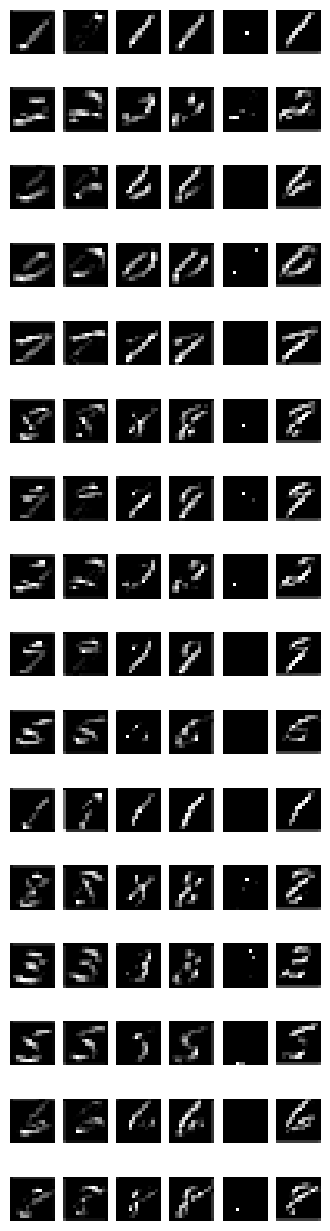

In [28]:
import matplotlib.pyplot as plt

rows=16
fig, axs = plt.subplots(rows, 6, figsize=(4,rows))

for n, ax in enumerate(axs.flat):
    image = x[n//6,n%6]
    ax.imshow(image,cmap='grey')
    ax.axis('off') 

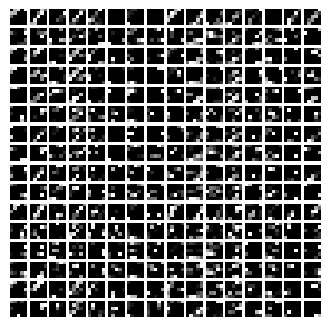

In [17]:
import matplotlib.pyplot as plt
rows = 16
fig, axs = plt.subplots(rows,rows, figsize=(rows // 4,rows // 4))

for n, ax in enumerate(axs.flat):
    image = y[n//rows,n%rows]
    ax.imshow(image,cmap='grey')
    ax.axis('off') 